In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader


In [3]:
df = pd.read_csv("go_emotions_dataset.csv")
df.drop('id', inplace=True, axis=1, errors='ignore')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   text                  4999 non-null   object
 1   example_very_unclear  4999 non-null   bool  
 2   admiration            4999 non-null   int64 
 3   amusement             4999 non-null   int64 
 4   anger                 4999 non-null   int64 
 5   annoyance             4999 non-null   int64 
 6   approval              4999 non-null   int64 
 7   caring                4999 non-null   int64 
 8   confusion             4999 non-null   int64 
 9   curiosity             4999 non-null   int64 
 10  desire                4999 non-null   int64 
 11  disappointment        4999 non-null   int64 
 12  disapproval           4999 non-null   int64 
 13  disgust               4999 non-null   int64 
 14  embarrassment         4999 non-null   int64 
 15  excitement            4999 non-null   

In [5]:
df.head()

,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,False,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
df.count

<bound method DataFrame.count of                                                    text  example_very_unclear  \
0                                       That game hurt.                 False   
1      >sexuality shouldn’t be a grouping category I...                  True   
2        You do right, if you don't care then fuck 'em!                 False   
3                                    Man I love reddit.                 False   
4     [NAME] was nowhere near them, he was by the Fa...                 False   
...                                                 ...                   ...   
4994  “What a bummer. He ded. I look at sky. Maybe b...                 False   
4995  This is exactly what happens when these fields...                 False   
4996  She had a reality show that actually showed he...                 False   
4997  Lol this pregame about players sucking and get...                 False   
4998  Sad to see this as a one-off. [NAME] seemed to...                 Fals

In [16]:
df.shape


(4999, 31)

In [17]:
emotions = set(df.columns[3:])
emotions

{'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'labels',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

In [18]:
positive = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love','optimism','pride','relief'}
negative = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness','remorse','grief','disgust'}
ambiguous = {'realization','surprise','curiosity','confusion','neutral'}

print(f'Fine grained emotions: {len(emotions)}')
print(f'Number of data: {len(df)}')
print(f'Number of positive emotions: {len(positive)}') 
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')

Fine grained emotions: 28
Number of data: 4999
Number of positive emotions: 12
Number of negative emotions: 11
Number of ambiguous emotions: 5


In [19]:
df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(positive)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(negative)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(ambiguous)] = 'ambiguous'
df_emotion.head(3)

C:\Users\DELL\AppData\Local\Temp\ipykernel_5632\2195006929.py:4: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\DELL\AppData\Local\Temp\ipykernel_5632\2195006929.py:5: FutureWarning:

ChainedAssignmentError: behaviour will change in 

,emotion,group
0,relief,positive
1,embarrassment,negative
2,realization,ambiguous


In [20]:
# Categorize Emotions
positive_col = ['admiration','amusement','approval','caring','curiosity','excitement','gratitude','joy','love','optimism','relief','surprise']
negative_col = ['sadness','pride','fear','embarrassment','disapproval','disappointment','confusion','annoyance','anger','nervousness','desire']
ambiguous_col = ['remorse','realization','grief','disgust']
neutral_col = ['neutral']
label_cols = positive_col + negative_col + ambiguous_col + neutral_col


## Exploratory Data Analysis

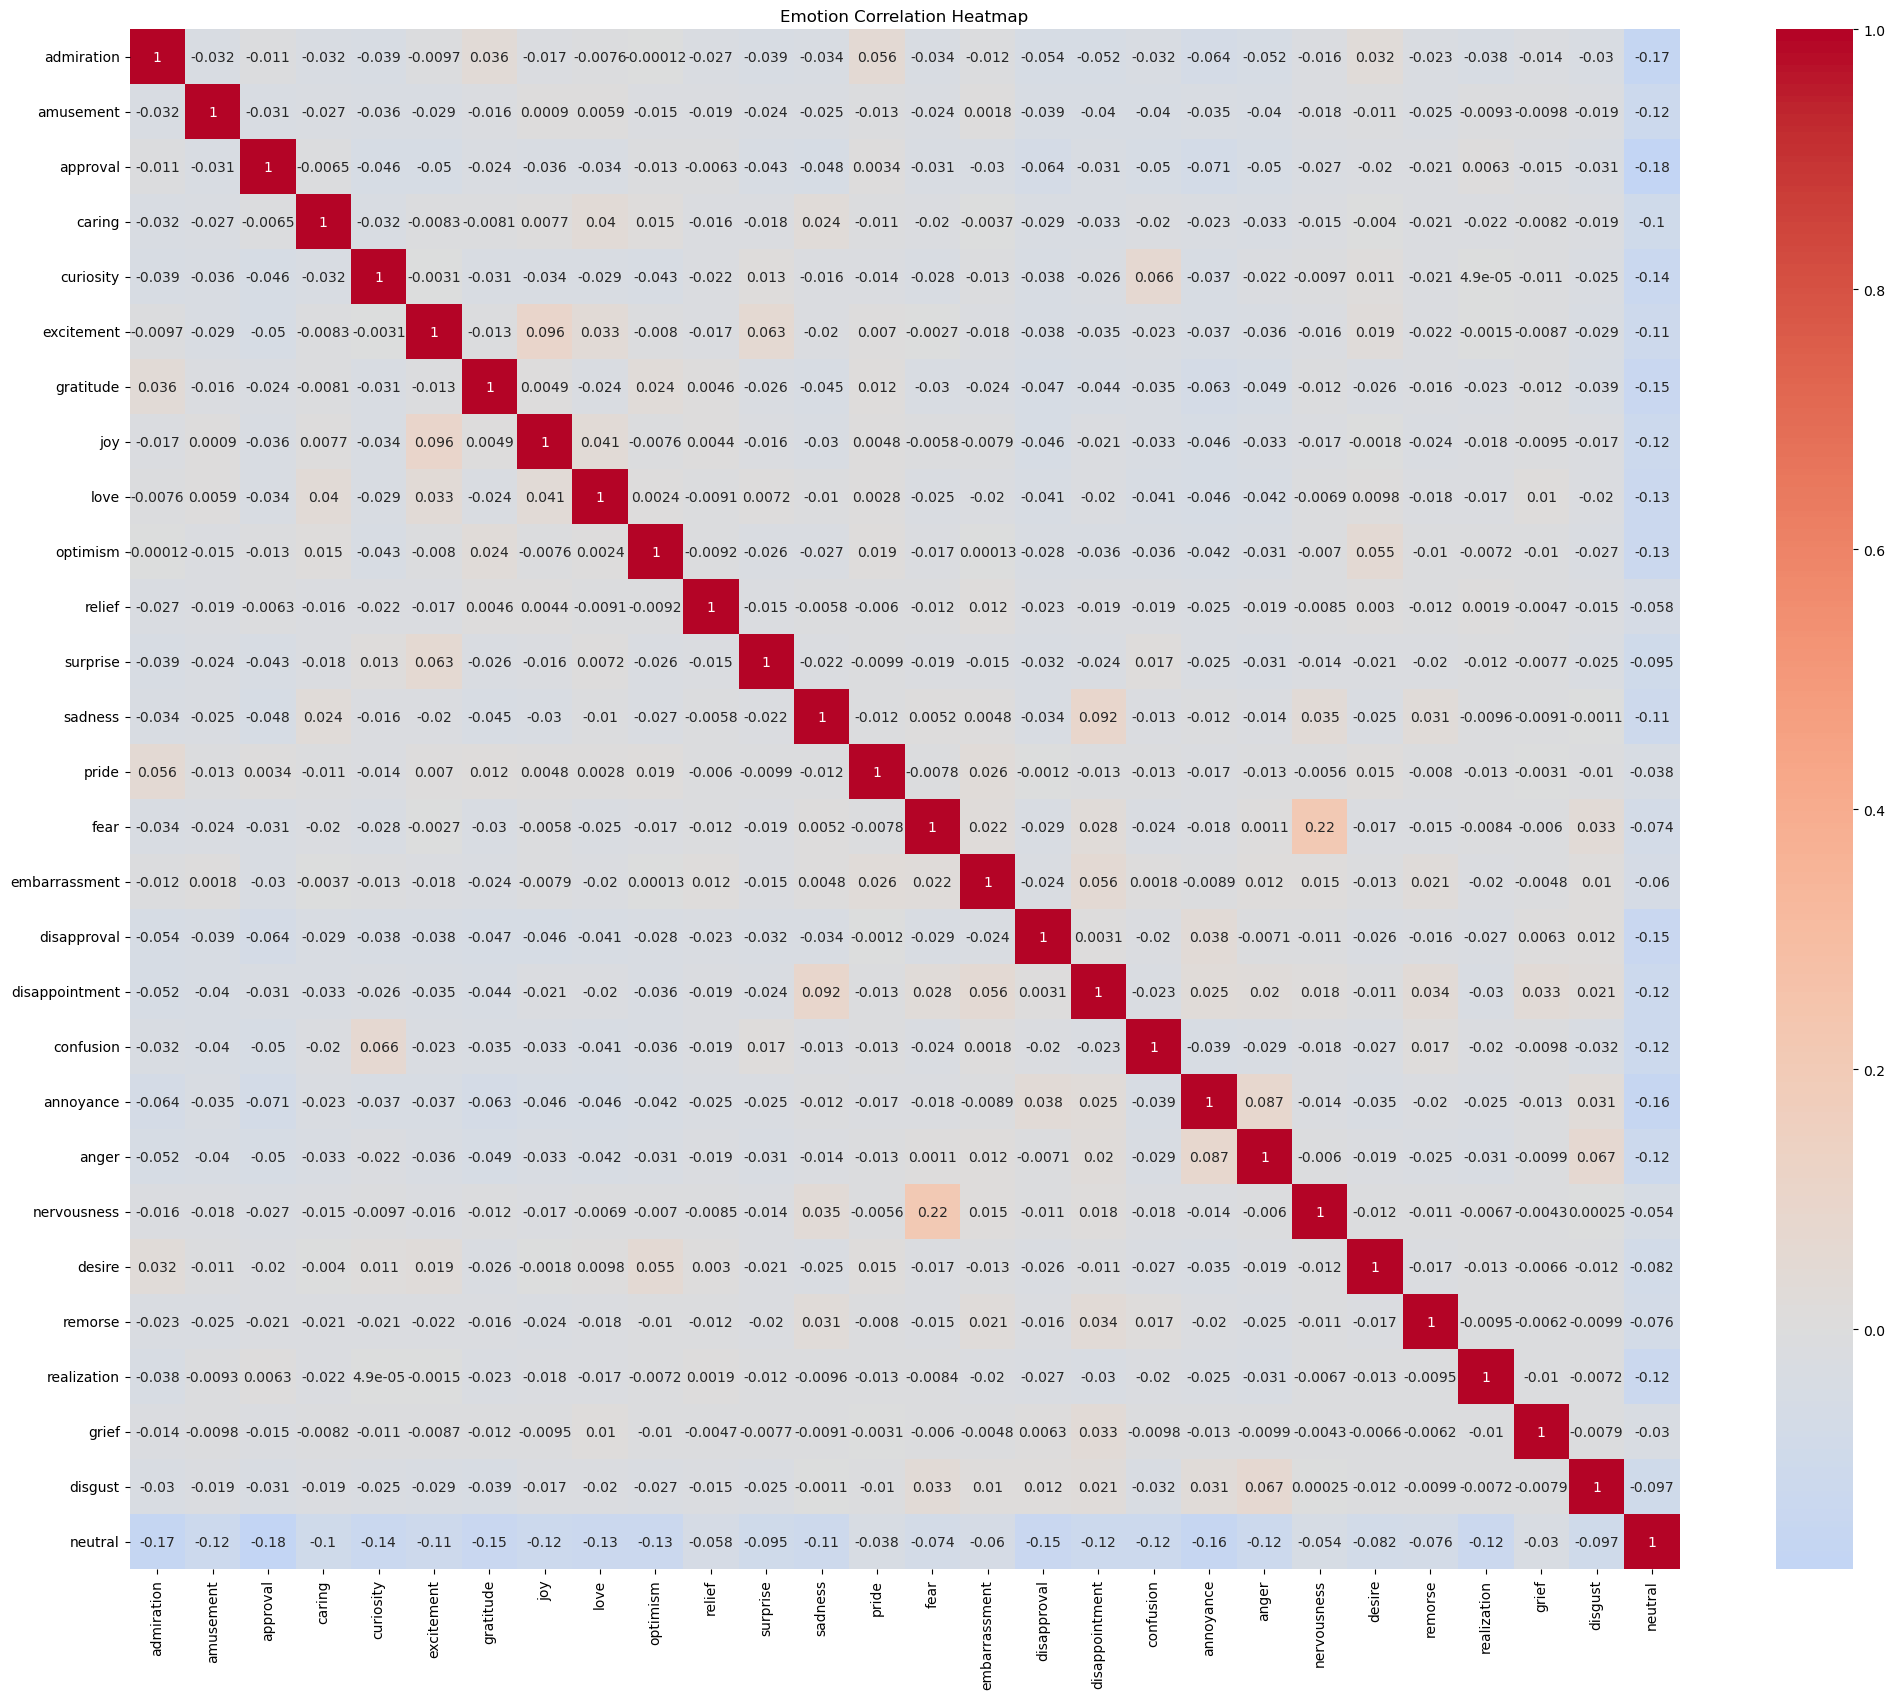

In [21]:
# Correlation Heatmap
plt.figure(figsize=(25,20))
sns.heatmap(df[label_cols].corr(), center=0, annot=True, cmap="coolwarm")
plt.title("Emotion Correlation Heatmap")
plt.show()

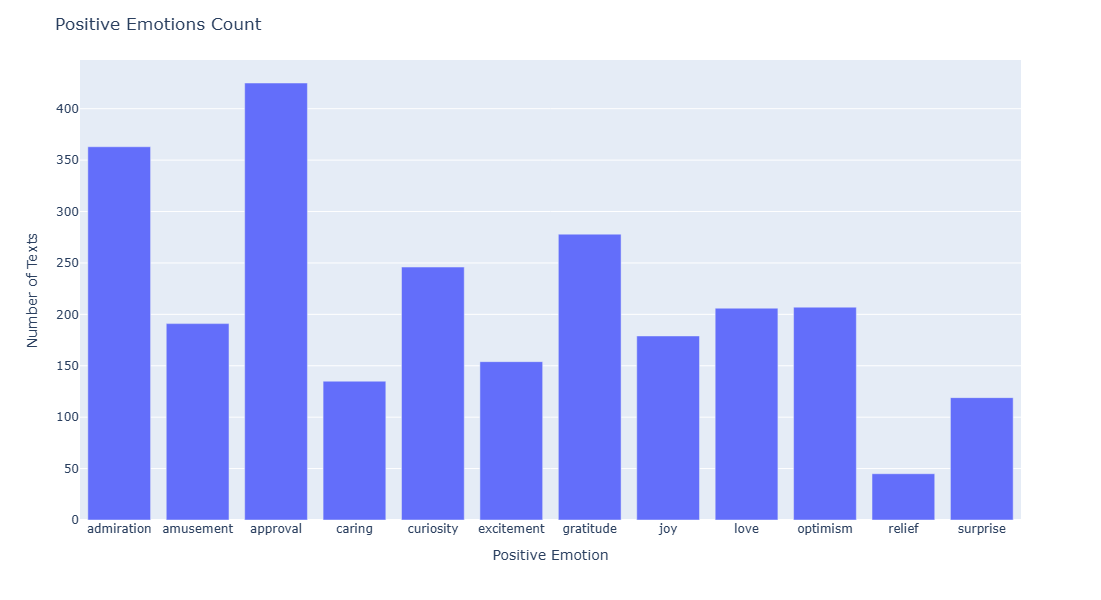

In [22]:
# Positive Emotion Counts
emotion_counts = {c: df[c].sum() for c in positive_col}
fig = px.bar(x=list(emotion_counts.keys()), y=list(emotion_counts.values()))
fig.update_layout(title='Positive Emotions Count', height=600, xaxis_title="Positive Emotion", yaxis_title="Number of Texts")
fig.show()

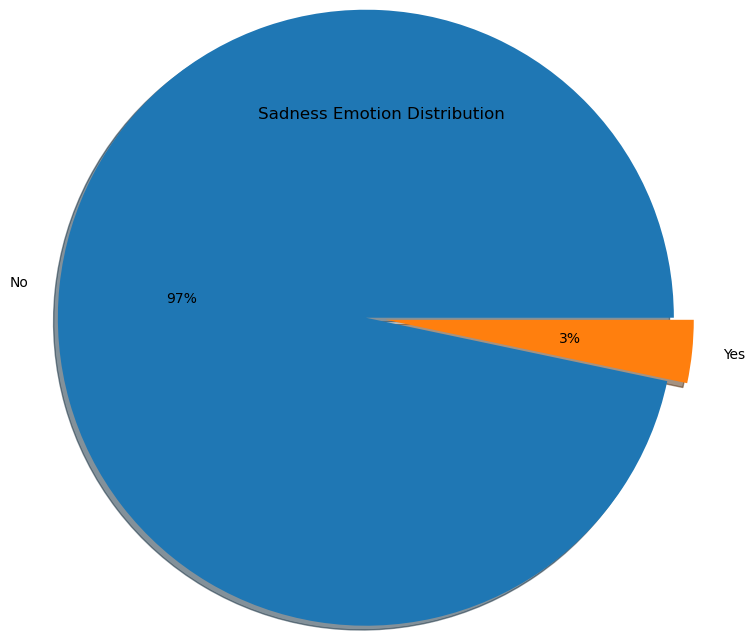

In [23]:
# Pie Chart Example - Sadness
plt.figure(figsize=(5, 5))
plt.pie(df['sadness'].value_counts(), labels=['No','Yes'],autopct='%.0f%%' , radius = 2 ,explode = (0.1,0.03),shadow = True)
plt.title("Sadness Emotion Distribution")
plt.show()

## Preprocessing

In [24]:
df['labels'] = df[label_cols].apply(lambda row: [label for label in label_cols if row[label] == 1], axis=1)
mlb = MultiLabelBinarizer(classes=label_cols)
labels = mlb.fit_transform(df['labels'])
texts = df['text'].tolist()

In [25]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [26]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [27]:
# Custom Dataset
class GoEmotionsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len, 
            return_token_type_ids=False, padding='max_length',
            return_attention_mask=True, return_tensors='pt', truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [28]:
train_data = GoEmotionsDataset(X_train, y_train, tokenizer)
test_data = GoEmotionsDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)


## Model Training

In [29]:
device = torch.device('cpu')  # Force CPU
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Train for 1 Epoch (more can be added)
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device) 
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
print(f"Training loss: {loss.item()}")

Training loss: 0.12581375241279602


## Evaluation

In [31]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.sigmoid(outputs.logits)
        predictions.extend(logits.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions) > 0.5
true_labels = np.array(true_labels)

In [32]:
# Metrics
print("Hamming Loss:", hamming_loss(true_labels, predictions))
print("F1 Score (micro):", f1_score(true_labels, predictions, average='micro'))
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_cols))


Hamming Loss: 0.04182142857142857
F1 Score (micro): 0.0
Classification Report:
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00        76
     amusement       0.00      0.00      0.00        37
      approval       0.00      0.00      0.00        88
        caring       0.00      0.00      0.00        21
     curiosity       0.00      0.00      0.00        41
    excitement       0.00      0.00      0.00        29
     gratitude       0.00      0.00      0.00        55
           joy       0.00      0.00      0.00        36
          love       0.00      0.00      0.00        37
      optimism       0.00      0.00      0.00        43
        relief       0.00      0.00      0.00         7
      surprise       0.00      0.00      0.00        34
       sadness       0.00      0.00      0.00        38
         pride       0.00      0.00      0.00         4
          fear       0.00      0.00      0.00        13
 embarrassment       0.0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaco

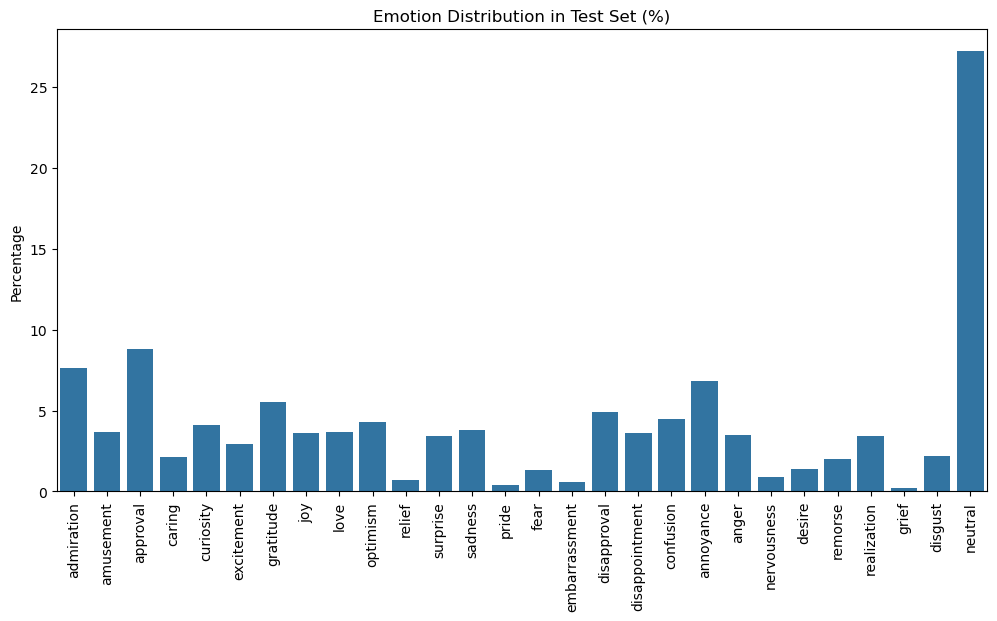

In [33]:
# Bar plot of emotion distribution in test set
emotion_percent = np.mean(y_test, axis=0) * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=label_cols, y=emotion_percent)
plt.xticks(rotation=90)
plt.title("Emotion Distribution in Test Set (%)")
plt.ylabel("Percentage")
plt.show()

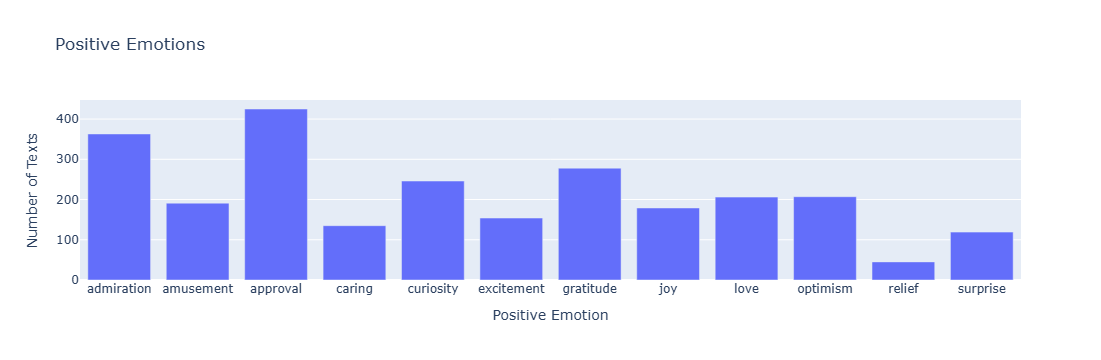

In [35]:
# Positive emotions barplot
positive_col = ['admiration','amusement','approval','caring','curiosity','excitement','gratitude','joy','love','optimism','relief','surprise']
emotion_counts = {col: df[col].sum() for col in positive_col}
fig = px.bar(x=list(emotion_counts.keys()), y=list(emotion_counts.values()), title='Positive Emotions')
fig.update_layout(xaxis_title="Positive Emotion", yaxis_title="Number of Texts")
fig.show()

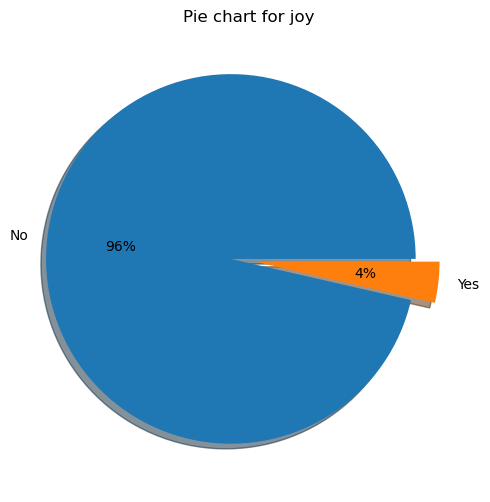

In [36]:
# Pie chart example
plt.figure(figsize=(6,6))
emotion = 'joy'
counts = df[emotion].value_counts()
plt.pie(counts, labels=['No', 'Yes'], autopct='%.0f%%', explode=(0.1, 0.03), shadow=True)
plt.title(f'Pie chart for {emotion}')
plt.show()

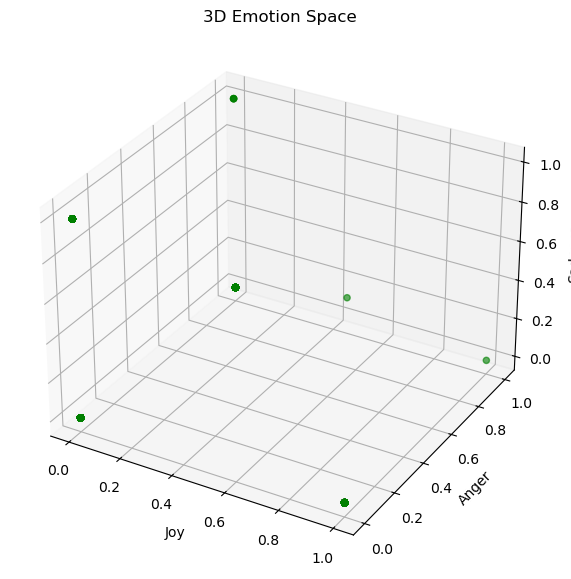

In [37]:
# 3D visualization (using first 3 emotions)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['joy'], df['anger'], df['sadness'], c='green', alpha=0.6)
ax.set_xlabel('Joy')
ax.set_ylabel('Anger')
ax.set_zlabel('Sadness')
plt.title("3D Emotion Space")
plt.show()

In [38]:
# Sample Real-World Prediction
sample_text = "I'm not sure how to feel about this update. It's confusing but somewhat exciting!"
encoding = tokenizer.encode_plus(sample_text, return_tensors='pt', padding="max_length", max_length=128, truncation=True)
encoding = {key: val.to(device) for key, val in encoding.items()}
model.eval()
with torch.no_grad():
    output = model(**encoding)
    probs = torch.sigmoid(output.logits).cpu().numpy()[0]
    predicted_emotions = [mlb.classes_[i] for i, p in enumerate(probs) if p > 0.5]
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: []


In [39]:
# After training
torch.save(model.state_dict(), "model.pt")
